In [1]:
import copy
import os
import random
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm

import cv2
from PIL import ImageFilter
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive

drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/DeepDRiD'


Mounted at /content/drive


In [3]:
df = pd.read_csv(f'{dataset_path}/train.csv')

print("Train dataset information:")
print(df.info())

print("\nFirst 5 Rows:")
print(df.head())

print("\nShape of the train set:", df.shape)

Train dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          1200 non-null   int64  
 1   image_id            1200 non-null   object 
 2   img_path            1200 non-null   object 
 3   Overall quality     1200 non-null   int64  
 4   left_eye_DR_Level   600 non-null    float64
 5   right_eye_DR_Level  600 non-null    float64
 6   patient_DR_Level    1200 non-null   int64  
 7   Clarity             1200 non-null   int64  
 8   Field definition    1200 non-null   int64  
 9   Artifact            1200 non-null   int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 93.9+ KB
None

First 5 Rows:
   patient_id image_id    img_path  Overall quality  left_eye_DR_Level  \
0           1     1_l1  1/1_l1.jpg                0                0.0   
1           1     1_l2  1/1_l2.jpg             

patient_DR_Level
0    360
2    240
1    240
3    240
4    120
Name: count, dtype: int64


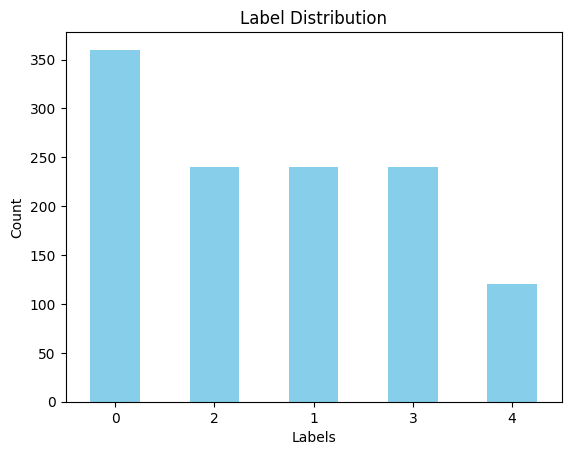

In [4]:
label_counts = df['patient_DR_Level'].value_counts()
print(label_counts)

label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
print(torch.cuda.is_available())
print(torch.version.cuda)


True
11.8


In [5]:
# Hyper Parameters
batch_size = 24
num_classes = 5  # 5 DR levels
learning_rate = 0.0001
num_epochs = 20


In [6]:
def set_random_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
def apply_clahe(img):
    lab = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return Image.fromarray(cv2.cvtColor(limg, cv2.COLOR_LAB2RGB))

In [77]:
class RetinopathyDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform=None, mode='single', test=False):
        self.ann_file = ann_file
        self.image_dir = image_dir
        self.transform = transform

        self.test = test
        self.mode = mode

        if self.mode == 'single':
            self.data = self.load_data()
        else:
            self.data = self.load_data_dual()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode == 'single':
            return self.get_item(index)
        else:
            return self.get_item_dual(index)

    # 1. single image
    def load_data(self):
        df = pd.read_csv(self.ann_file)

        data = []
        for _, row in df.iterrows():
            file_info = dict()
            file_info['img_path'] = os.path.join(self.image_dir, row['img_path'])
            if not self.test:
                file_info['dr_level'] = int(row['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item(self, index):
        data = self.data[index]
        img = Image.open(data['img_path']).convert('RGB')

        if self.transform:
            img = self.transform(img)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return img, label
        else:
            return img

    # 2. dual image
    def load_data_dual(self):
        df = pd.read_csv(self.ann_file)

        df['prefix'] = df['image_id'].str.split('_').str[0]  # The patient id of each image
        df['suffix'] = df['image_id'].str.split('_').str[1].str[0]  # The left or right eye
        grouped = df.groupby(['prefix', 'suffix'])

        data = []
        for (prefix, suffix), group in grouped:
            file_info = dict()
            file_info['img_path1'] = os.path.join(self.image_dir, group.iloc[0]['img_path'])
            file_info['img_path2'] = os.path.join(self.image_dir, group.iloc[1]['img_path'])
            if not self.test:
                file_info['dr_level'] = int(group.iloc[0]['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item_dual(self, index):
        data = self.data[index]
        img1 = Image.open(data['img_path1']).convert('RGB')
        img2 = Image.open(data['img_path2']).convert('RGB')

        img1 = apply_clahe(img1)
        img2 = apply_clahe(img2)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return [img1, img2], label
        else:
            return [img1, img2]


# **Data Augmentations**

In [9]:
class CutOut(object):
    def __init__(self, mask_size, p=0.5):
        self.mask_size = mask_size
        self.p = p

    def __call__(self, img):
        if np.random.rand() > self.p:
            return img

        # Ensure the image is a tensor
        if not isinstance(img, torch.Tensor):
            raise TypeError('Input image must be a torch.Tensor')

        # Get height and width of the image
        h, w = img.shape[1], img.shape[2]
        mask_size_half = self.mask_size // 2
        offset = 1 if self.mask_size % 2 == 0 else 0

        cx = np.random.randint(mask_size_half, w + offset - mask_size_half)
        cy = np.random.randint(mask_size_half, h + offset - mask_size_half)

        xmin, xmax = cx - mask_size_half, cx + mask_size_half + offset
        ymin, ymax = cy - mask_size_half, cy + mask_size_half + offset
        xmin, xmax = max(0, xmin), min(w, xmax)
        ymin, ymax = max(0, ymin), min(h, ymax)

        img[:, ymin:ymax, xmin:xmax] = 0
        return img

In [10]:
class SLORandomPad:
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        pad_width = max(0, self.size[0] - img.width)
        pad_height = max(0, self.size[1] - img.height)
        pad_left = random.randint(0, pad_width)
        pad_top = random.randint(0, pad_height)
        pad_right = pad_width - pad_left
        pad_bottom = pad_height - pad_top
        return transforms.functional.pad(img, (pad_left, pad_top, pad_right, pad_bottom))

In [11]:
class FundRandomRotate:
    def __init__(self, prob, degree):
        self.prob = prob
        self.degree = degree

    def __call__(self, img):
        if random.random() < self.prob:
            angle = random.uniform(-self.degree, self.degree)
            return transforms.functional.rotate(img, angle)
        return img

In [12]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((210, 210)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [13]:
def compute_metrics(preds, labels, per_class=False):
    kappa = cohen_kappa_score(labels, preds, weights='quadratic')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)

    # Calculate and print precision and recall for each class
    if per_class:
        precision_per_class = precision_score(labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(labels, preds, average=None, zero_division=0)
        return kappa, accuracy, precision, recall, precision_per_class, recall_per_class

    return kappa, accuracy, precision, recall

**Model Evaluation**

In [14]:
def evaluate_model(model, test_loader, device, test_only=False, prediction_path='./test_predictions.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        metrics = compute_metrics(all_preds, all_labels)
        return metrics

**Model Training**

In [15]:
def train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=25,
                checkpoint_path='model.pth'):
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0  # Initialize the best kappa score

    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        model.train()

        with tqdm(total=len(train_loader), desc=f'Training', unit=' batch', file=sys.stdout) as pbar:
            for images, labels in train_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # single image case
                else:
                    images = [x.to(device) for x in images]  # dual images case

                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels.long())

                loss.backward()
                optimizer.step()

                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss.append(loss.item())

                pbar.set_postfix({'lr': f'{optimizer.param_groups[0]["lr"]:.1e}', 'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()

        epoch_loss = sum(running_loss) / len(running_loss)

        train_metrics = compute_metrics(all_preds, all_labels, per_class=True)
        kappa, accuracy, precision, recall = train_metrics[:4]

        print(f'[Train] Kappa: {kappa:.4f} Accuracy: {accuracy:.4f} '
              f'Precision: {precision:.4f} Recall: {recall:.4f} Loss: {epoch_loss:.4f}')

        if len(train_metrics) > 4:
            precision_per_class, recall_per_class = train_metrics[4:]
            for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
                print(f'[Train] Class {i}: Precision: {precision:.4f}, Recall: {recall:.4f}')

        # Evaluation on the validation set at the end of each epoch
        val_metrics = evaluate_model(model, val_loader, device)
        val_kappa, val_accuracy, val_precision, val_recall = val_metrics[:4]
        print(f'[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} '
              f'Precision: {val_precision:.4f} Recall: {val_recall:.4f}')

        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

    print(f'[Val] Best kappa: {best_val_kappa:.4f}, Epoch {best_epoch}')

    return model

# **Task A:** Fine-tune a pre-trained model using the DeepDRiD dataset

**Models**

In [ ]:
class MyModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

In [ ]:
class MyDualModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        backbone = models.resnet18(pretrained=True)
        backbone.fc = nn.Identity()

        # Here the two backbones will have the same structure but unshared weights
        self.backbone1 = copy.deepcopy(backbone)
        self.backbone2 = copy.deepcopy(backbone)

        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, images):
        image1, image2 = images

        x1 = self.backbone1(image1)
        x2 = self.backbone2(image2)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x

In [ ]:
#set_random_seed(40)

# Choose between 'single image' and 'dual images' pipeline
# This will affect the model definition, dataset pipeline, training and evaluation

# mode = 'single'  # forward single image to the model each time
mode = 'dual'  # forward two images of the same eye to the model and fuse the features

assert mode in ('single', 'dual')

# Define the model
if mode == 'single':
    model = MyModel()
else:
    model = MyDualModel()

print(model, '\n')
print('Pipeline Mode:', mode)

# Create dataset
train_dataset = RetinopathyDataset('./DeepDRiD/train.csv', './DeepDRiD/train/', transform_train, mode)
val_dataset = RetinopathyDataset('./DeepDRiD/val.csv', './DeepDRiD/val/', transform_test, mode)
test_dataset = RetinopathyDataset('./DeepDRiD/test.csv', './DeepDRiD/test/', transform_test, mode, test=True)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Use GPU device is possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Move class weights to the device
model = model.to(device)

# Optimizer and Learning rate scheduler
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train and evaluate the model with the training and validation set
model = train_model(
    model, train_loader, val_loader, device, criterion, optimizer,
    lr_scheduler=lr_scheduler, num_epochs=num_epochs,
    checkpoint_path='./model_1.pth'
)

# Load the pretrained checkpoint
state_dict = torch.load('./model_1.pth', map_location='cpu')
model.load_state_dict(state_dict, strict=True)

# Make predictions on testing set and save the prediction results
evaluate_model(model, test_loader, device, test_only=True)

C:\Users\mehsanim24\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mehsanim24\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyDualModel(
  (backbone1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

C:\Users\mehsanim24\AppData\Local\Temp\ipykernel_4508\865991982.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('./model_1.pth', map_location='c

Evaluating: 100%|██████████| 9/9 [00:03<00:00,  2.90 batch/s]
[Test] Save predictions to c:\Users\mehsanim24\Desktop\taskd-2\taskd-2\test_predictions.csv


# **Task B:** Two-stage training with additional datasets

**Part 1: fine-tuning on APTOS dataset**

In [ ]:
class APTOSDataset(Dataset):
    def __init__(self, ann_file, img_dir, transform=None, test=False):
        self.data = pd.read_csv(ann_file)
        self.img_dir = img_dir
        self.transform = transform
        self.test = test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id = self.data.iloc[idx]['id_code']
        label = int(self.data.iloc[idx]['diagnosis'])

        img_path = os.path.join(self.img_dir, f"{img_id}.png")
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        if self.test:
            return image
        else:
            label = int(self.data.iloc[idx]['diagnosis'])
            return image, label


In [ ]:
class MyEnhancedModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.4):
        super().__init__()

        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.flatten = nn.Flatten()

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [ ]:
def evaluate_APTOS_model(model, test_loader, device, test_only=False, prediction_path='./test_predictions_APTOS.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            # Handle single image case
            images = images.to(device)

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            # Extract predictions and IDs for single images
            all_preds.extend(preds.cpu().numpy())

            # Get the corresponding IDs from the DataFrame
            start_idx = i * test_loader.batch_size
            end_idx = start_idx + len(images)
            image_ids = test_loader.dataset.data.iloc[start_idx:end_idx]['id_code'].tolist()
            all_image_ids.extend(image_ids)

            # Add labels if not in test_only mode
            if not test_only:
                all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to CSV file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        metrics = compute_metrics(all_preds, all_labels)
        return metrics


In [ ]:
set_random_seed(40)

# Choose between 'single image' and 'dual images' pipeline
# This will affect the model definition, dataset pipeline, training and evaluation

mode = 'single'  # forward single image to the model each time
# mode = 'dual'  # forward two images of the same eye to the model and fuse the features

assert mode in ('single', 'dual')

# Define the model
if mode == 'single':
    model = MyEnhancedModel()
else:
    model = MyDualModel()

print(model, '\n')
print('Pipeline Mode:', mode)

# Create APTOS dataset
train_APTOSdataset = APTOSDataset('./APTOS-2019 dataset/train_1.csv', './APTOS-2019 dataset/train_images/train_images/', transform_train)
val_APTOSdataset = APTOSDataset('./APTOS-2019 dataset/valid.csv', './APTOS-2019 dataset/val_images/val_images/', transform_test)
test_APTOSdataset = APTOSDataset('./APTOS-2019 dataset/test.csv', './APTOS-2019 dataset/test_images/test_images/', transform_test, test=True)
# Create dataloaders
train_APTOSloader = DataLoader(train_APTOSdataset, batch_size=batch_size, shuffle=True)
val_APTOSloader = DataLoader(val_APTOSdataset, batch_size=batch_size, shuffle=False)
test_APTOSloader = DataLoader(test_APTOSdataset, batch_size=batch_size, shuffle=False)

# Define the weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Use GPU device is possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Move class weights to the device
model = model.to(device)

# Optimizer and Learning rate scheduler
# optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=0.001)

optimizer = torch.optim.Adam([
{'params': model.backbone.parameters(), 'lr': 1e-4},  # Smaller LR for backbone
{'params': model.fc.parameters(), 'lr': 1e-3}        # Larger LR for FC layers
])

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train and evaluate the model with the training and validation set
model = train_model(
    model, train_APTOSloader, val_APTOSloader, device, criterion, optimizer,
    lr_scheduler=lr_scheduler, num_epochs=num_epochs,
    checkpoint_path='./model_APTOS.pth'
)

# Load the pretrained checkpoint
state_dict = torch.load('./model_APTOS.pth', map_location='cpu')
model.load_state_dict(state_dict, strict=True)

# Make predictions on testing set and save the prediction results
evaluate_APTOS_model(model, test_APTOSloader, device, test_only=True)

**Part 2: fine-tuning APTOS model on DeepDRID dataset**

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((210, 210)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.RandomSolarize(threshold=0.5, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3))
])

In [ ]:
class MyModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.densenet121(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(1000, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

In [ ]:
#set_random_seed(40)

# Choose between 'single image' and 'dual images' pipeline
# This will affect the model definition, dataset pipeline, training and evaluation

mode = 'single'  # forward single image to the model each time
# mode = 'dual'  # forward two images of the same eye to the model and fuse the features

assert mode in ('single', 'dual')

# Define the model
if mode == 'single':
    model = MyModel()
else:
    model = MyDualModel()

state_dict = torch.load('.\model_APTOS.pth')
model.backbone.load_state_dict(state_dict, strict=False)

print(model, '\n')
print('Pipeline Mode:', mode)

# Create datasets
train_dataset = RetinopathyDataset('./DeepDRiD/train.csv', './DeepDRiD/train/', transform_train, mode)
val_dataset = RetinopathyDataset('./DeepDRiD/val.csv', './DeepDRiD/val/', transform_test, mode)
test_dataset = RetinopathyDataset('./DeepDRiD/test.csv', './DeepDRiD/test/', transform_test, mode, test=True)
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Use GPU device is possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Move class weights to the device
model = model.to(device)

# Optimizer and Learning rate scheduler
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=0.001)

# optimizer = torch.optim.Adam([
# {'params': model.backbone.parameters(), 'lr': 1e-4},  # Smaller LR for backbone
# {'params': model.fc.parameters(), 'lr': 1e-3}        # Larger LR for FC layers
# ])

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model = train_model(
    model, train_loader, val_loader, device, criterion, optimizer,
    lr_scheduler=lr_scheduler, num_epochs=num_epochs,
    checkpoint_path='./model_deepdrid.pth'
)

# Load the pretrained checkpoint
state_dict = torch.load('./model_deepdrid.pth', map_location='cpu')
model.load_state_dict(state_dict, strict=True)

# Make predictions on testing set and save the prediction results
evaluate_model(model, test_loader, device, test_only=True)

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
C:\Users\mehsanim24\AppData\Local\Temp\ipykernel_4508\1580658461.py:17: SyntaxWarning: invalid escape sequence '\m'
  state_dict = torch.load('.\model_APTOS.pth')
C:\Users\mehsanim24\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mehsanim24\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\mehsanim24\AppData\Local\Temp\ipykernel_450

MyModel(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.

C:\Users\mehsanim24\AppData\Local\Temp\ipykernel_4508\1580658461.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('./model_deepdrid.pth', map_loc


[Val] Kappa: 0.8128 Accuracy: 0.6475 Precision: 0.6318 Recall: 0.6475
[Val] Best kappa: 0.8412, Epoch 3
Evaluating: 100%|██████████| 17/17 [00:02<00:00,  5.98 batch/s]
[Test] Save predictions to c:\Users\mehsanim24\Desktop\taskd-2\taskd-2\test_predictions.csv


# **Task C:** Incorporate attention mechanisms in the model

**Spatial Attention**

In [ ]:
class AttentionConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, padding=0, bias=False):
        super(AttentionConv, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=1, padding=padding, bias=bias)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x

class SpatialAttention(nn.Module):
    def __init__(self, kernel=7):
        super(SpatialAttention, self).__init__()
        self.conv = AttentionConv(2, 1, kernel_size=kernel, padding=(kernel - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, 1).unsqueeze(1)
        max_out = torch.max(x, 1)[0].unsqueeze(1)

        combined = torch.cat((avg_out, max_out), dim=1)
        attention = self.sigmoid(self.conv(combined))

        return x * attention


class MySpatialAttentionModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.densenet121(pretrained=True)
        self.backbone.classifier = nn.Identity()

        self.spatial_attention = SpatialAttention(kernel=7)

        self.fc = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.backbone.features(x)
        features = self.spatial_attention(features)

        pooled_features = F.adaptive_avg_pool2d(features, (1, 1))
        pooled_features = torch.flatten(pooled_features, 1)

        output = self.fc(pooled_features)
        return output

**Channel Attention**

In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, gate_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)  # Add max pooling
        self.fc = nn.Sequential(
            nn.Linear(gate_channels, gate_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(gate_channels // reduction, gate_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch, channel, _, _ = x.size()

        avg_out = self.avg_pool(x).view(batch, channel)
        avg_weights = self.fc(avg_out)
        max_out = self.max_pool(x).view(batch, channel)
        max_weights = self.fc(max_out)

        attention_weights = avg_weights + max_weights

        return x * attention_weights.view(batch, channel, 1, 1)


class MyChannelAttentionModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.densenet121(pretrained=True)
        self.backbone.classifier = nn.Identity()

        self.channel_attention = ChannelAttention(channels=1024, reduction=16)

        self.fc = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.backbone.features(x)
        features = self.channel_attention(features)

        pooled_features = F.adaptive_avg_pool2d(features, (1, 1))
        pooled_features = torch.flatten(pooled_features, 1)

        output = self.fc(pooled_features)
        return output


**Self-attention**

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 4, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 4, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.size()

        query = self.query(x).view(B, -1, H * W).permute(0, 2, 1)
        key = self.key(x).view(B, -1, H * W)
        value = self.value(x).view(B, -1, H * W)

        attention = torch.bmm(query, key)
        attention = F.softmax(attention, dim=-1)

        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        out = self.gamma * out + x

        return out


class MySelfAttentionModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.densenet121(pretrained=True)
        self.backbone.classifier = nn.Identity()

        self.self_attention = SelfAttention(in_channels=1024)

        self.fc = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.backbone.features(x)
        features = self.self_attention(features)

        pooled_features = F.adaptive_avg_pool2d(features, (1, 1))
        pooled_features = torch.flatten(pooled_features, 1)

        output = self.fc(pooled_features)
        return output

In [ ]:
#set_random_seed(40)

mode = 'single'  # forward single image to the model each time
# mode = 'dual'  # forward two images of the same eye to the model and fuse the features

assert mode in ('single', 'dual')

# Define the model
if mode == 'single':
    model = MySelfAttentionModel()
else:
    model = MyDualModel()

state_dict = torch.load('.\model_deepdrid.pth')
model.backbone.load_state_dict(state_dict, strict=False)

print(model, '\n')
print('Pipeline Mode:', mode)

# Create datasets
train_dataset = RetinopathyDataset('./DeepDRiD/train.csv', './DeepDRiD/train/', transform_train, mode)
val_dataset = RetinopathyDataset('./DeepDRiD/val.csv', './DeepDRiD/val/', transform_test, mode)
test_dataset = RetinopathyDataset('./DeepDRiD/test.csv', './DeepDRiD/test/', transform_test, mode, test=True)
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Use GPU device is possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Move class weights to the device
model = model.to(device)

# Optimizer and Learning rate scheduler
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=0.001)

# optimizer = torch.optim.Adam([
# {'params': model.backbone.parameters(), 'lr': 1e-4},  # Smaller LR for backbone
# {'params': model.fc.parameters(), 'lr': 1e-3}        # Larger LR for FC layers
# ])

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model = train_model(
    model, train_loader, val_loader, device, criterion, optimizer,
    lr_scheduler=lr_scheduler, num_epochs=num_epochs,
    checkpoint_path='./model_deepdrid_attention.pth'
)

# Load the pretrained checkpoint
state_dict = torch.load('./model_deepdrid_attention.pth', map_location='cpu')
model.load_state_dict(state_dict, strict=True)

# Make predictions on testing set and save the prediction results
evaluate_model(model, test_loader, device, test_only=True)


<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
C:\Users\mehsanim24\AppData\Local\Temp\ipykernel_4508\387159962.py:14: SyntaxWarning: invalid escape sequence '\m'
  state_dict = torch.load('.\model_deepdrid.pth')
C:\Users\mehsanim24\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mehsanim24\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\mehsanim24\AppData\Local\Temp\ipykernel_4

MySelfAttentionModel(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05

C:\Users\mehsanim24\AppData\Local\Temp\ipykernel_4508\387159962.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('./model_deepdrid_attention.pth'


[Val] Kappa: 0.7928 Accuracy: 0.6550 Precision: 0.6376 Recall: 0.6550
[Val] Best kappa: 0.8442, Epoch 6
Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.49 batch/s]
[Test] Save predictions to c:\Users\mehsanim24\Desktop\taskd-2\taskd-2\test_predictions.csv


# **Task D:** Compare the performance of different models and strategies

For the ensemble techniques, i get better results when not using CLAHE in my dataset.

In [76]:
set_random_seed(40)

In [16]:
class MyDensenetModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.densenet121(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(1000, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

In [17]:
class MyResnet18Model(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

In [18]:
class MyResnet34Model(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet34(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

In [78]:
def load_model_weights(model_class, weight_path, num_classes=5):
    model = model_class(num_classes=num_classes)
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.to(device)
    model.eval()
    return model


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

model_resnet18 = load_model_weights(MyResnet18Model, './model_taskd_resnet18.pth')
model_resnet34 = load_model_weights(MyResnet34Model, './model_taskd_resnet34.pth')
model_densenet121 = load_model_weights(MyDensenetModel, './model_taskd_densenet121.pth')

# Create datasets
train_dataset = RetinopathyDataset(f'{dataset_path}/train.csv', f'{dataset_path}/train/', transform_train, mode='single')
val_dataset = RetinopathyDataset(f'{dataset_path}/val.csv', f'{dataset_path}/val', transform_test, mode='single')
test_dataset = RetinopathyDataset(f'{dataset_path}/test.csv', f'{dataset_path}/test', transform_test, mode='single', test=True)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Device: cuda


<ipython-input-78-e9d6843ee635>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path, map_location=device))


**Soft Voting**

In [56]:
class SoftVoting(nn.Module):
    def __init__(self, models, num_classes=5):
        super().__init__()
        self.models = nn.ModuleList(models)
        self.num_classes = num_classes

    def forward(self, x):
        outputs = [F.softmax(model(x), dim=1) for model in self.models]
        avg_output = torch.stack(outputs).mean(dim=0)
        return avg_output

In [57]:
def evaluate_softvoting(ensemble_model, data_loader, device):
    ensemble_model.eval()
    all_preds = []
    all_labels = []

    with tqdm(total=len(data_loader), desc='Evaluating Ensemble', unit='batch') as pbar:
        for images, labels in data_loader:
            if isinstance(images, list):
                images = [img.to(device) for img in images]
            else:
                images = images.to(device)

            labels = labels.to(device)

            with torch.no_grad():
                outputs = ensemble_model(images)
                preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            pbar.update(1)

    metrics = compute_metrics(all_preds, all_labels)
    print(f'Validation Metrics: Kappa: {metrics[0]:.4f}, Accuracy: {metrics[1]:.4f}, '
          f'Precision: {metrics[2]:.4f}, Recall: {metrics[3]:.4f}')
    return metrics

def predict_softvoting(ensemble_model, data_loader, device, output_csv='test_predictions.csv'):
    ensemble_model.eval()
    all_preds = []
    all_image_ids = []

    with tqdm(total=len(data_loader), desc='Generating Predictions', unit='batch') as pbar:
        for images in data_loader:
            if isinstance(images, list):  # Dual image mode
                images = [img.to(device) for img in images]
            else:  # Single image mode
                images = images.to(device)

            with torch.no_grad():
                outputs = ensemble_model(images)
                preds = torch.argmax(outputs, dim=1)

            batch_image_ids = [
                os.path.basename(data_loader.dataset.data[idx]['img_path']) for idx in range(
                    pbar.n * data_loader.batch_size,
                    pbar.n * data_loader.batch_size + len(images)
                )
            ]
            all_image_ids.extend(batch_image_ids)
            all_preds.extend(preds.cpu().numpy())
            pbar.update(1)

    df = pd.DataFrame({'ID': all_image_ids, 'TARGET': all_preds})
    df.to_csv(output_csv, index=False)
    print(f'Predictions saved to {output_csv}')

In [79]:
ensemble_model = SoftVoting([model_resnet18, model_resnet34, model_densenet121])

val_metrics = evaluate_softvoting(ensemble_model, val_loader, device)

predict_softvoting(ensemble_model, test_loader, device, output_csv='test_predictions.csv')

Evaluating Ensemble: 100%|██████████| 17/17 [00:05<00:00,  3.31batch/s]


Validation Metrics: Kappa: 0.8614, Accuracy: 0.7050, Precision: 0.6787, Recall: 0.7050


Generating Predictions: 100%|██████████| 17/17 [00:05<00:00,  2.92batch/s]

Predictions saved to test_predictions.csv


In [80]:
def evaluate_hardvoting(ensemble_model, data_loader, device):
    ensemble_model.eval()
    all_preds = []
    all_labels = []

    with tqdm(total=len(data_loader), desc='Evaluating Ensemble', unit='batch') as pbar:
        for images, labels in data_loader:
            if isinstance(images, list):
                images = [img.to(device) for img in images]
            else:
                images = images.to(device)

            labels = labels.to(device)

            with torch.no_grad():
                preds = ensemble_model(images)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            pbar.update(1)

    metrics = compute_metrics(all_preds, all_labels)
    print(f'metrics: Kappa: {metrics[0]:.4f}, Accuracy: {metrics[1]:.4f}, '
          f'Precision: {metrics[2]:.4f}, Recall: {metrics[3]:.4f}')
    return metrics

def predict_hardvoting(ensemble_model, data_loader, device, output_csv='test_predictions.csv'):
    ensemble_model.eval()
    all_preds = []
    all_image_ids = []

    with tqdm(total=len(data_loader), desc='Generating Predictions', unit='batch') as pbar:
        for images in data_loader:
            if isinstance(images, list):  # Dual image mode
                images = [img.to(device) for img in images]
            else:  # Single image mode
                images = images.to(device)

            with torch.no_grad():
                preds = ensemble_model(images)

            batch_image_ids = [
                os.path.basename(data_loader.dataset.data[idx]['img_path']) for idx in range(
                    pbar.n * data_loader.batch_size,
                    pbar.n * data_loader.batch_size + len(images)
                )
            ]
            all_image_ids.extend(batch_image_ids)
            all_preds.extend(preds.cpu().numpy())
            pbar.update(1)

    df = pd.DataFrame({'ID': all_image_ids, 'TARGET': all_preds})
    df.to_csv(output_csv, index=False)
    print(f'Predictions saved to {output_csv}')

In [81]:
class HardVotingEnsemble(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models)

    def forward(self, x):
        outputs = []
        for model in self.models:
            outputs.append(torch.argmax(model(x), dim=1))

        outputs = torch.stack(outputs, dim=0)
        output = torch.mode(outputs, dim=0).values

        return output


In [82]:
ensemble_model = HardVotingEnsemble([model_resnet18, model_resnet34, model_densenet121])

val_metrics = evaluate_hardvoting(ensemble_model, val_loader, device)

predict_hardvoting(ensemble_model, test_loader, device, output_csv='test_predictions.csv')

Evaluating Ensemble: 100%|██████████| 17/17 [00:05<00:00,  3.24batch/s]


metrics: Kappa: 0.8598, Accuracy: 0.7075, Precision: 0.6867, Recall: 0.7075


Generating Predictions: 100%|██████████| 17/17 [00:06<00:00,  2.74batch/s]

Predictions saved to test_predictions.csv


In [89]:
class WeightedAverageEnsemble(nn.Module):
    def __init__(self, models, weights):
        super().__init__()
        self.models = nn.ModuleList(models)
        self.weights = weights

    def forward(self, x):
        outputs = []
        for model, weight in zip(self.models, self.weights):
            outputs.append(weight * F.softmax(model(x), dim=1))
        output = torch.stack(outputs, dim=0).sum(dim=0)

        return output

In [90]:
ensemble_model = WeightedAverageEnsemble([model_resnet18, model_resnet34, model_densenet121], weights = [0.2, 0.3, 0.5])

val_metrics = evaluate_softvoting(ensemble_model, val_loader, device)

predict_softvoting(ensemble_model, test_loader, device, output_csv='test_predictions.csv')

Evaluating Ensemble: 100%|██████████| 17/17 [00:05<00:00,  3.31batch/s]


Validation Metrics: Kappa: 0.8662, Accuracy: 0.7200, Precision: 0.7003, Recall: 0.7200


Generating Predictions: 100%|██████████| 17/17 [00:05<00:00,  3.04batch/s]

Predictions saved to test_predictions.csv


**Stacking**

In [45]:
base_models = [model_resnet18, model_resnet34, model_densenet121]

In [49]:
def get_predictions(base_models, loader, device, test=False):
    meta_features = []
    meta_labels = []
    image_ids = []

    for i, batch in enumerate(loader):
        if test:
            images = batch
            labels = None
        else:
            images, labels = batch

        images = images.to(device)
        base_outputs = [model(images).detach().cpu().numpy() for model in base_models]
        meta_features.append(np.concatenate(base_outputs, axis=1))
        if not test:
            meta_labels.extend(labels.numpy())

        if test:
            start_idx = i * loader.batch_size
            end_idx = start_idx + len(images)
            image_ids.extend(
                [os.path.basename(loader.dataset.data[idx]['img_path']) for idx in range(start_idx, end_idx)]
            )

    if test:
        return np.vstack(meta_features), image_ids
    else:
        return np.vstack(meta_features), np.array(meta_labels)

In [85]:
X_meta_train, y_meta_train = get_predictions(base_models, train_loader, device)

In [86]:
from sklearn.linear_model import LogisticRegression

meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X_meta_train, y_meta_train)

LogisticRegression(max_iter=1000)

In [87]:
X_meta_val, y_meta_val = get_predictions(base_models, val_loader, device)
y_val_pred = meta_model.predict(X_meta_val)
val_accuracy = accuracy_score(y_meta_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.6450


In [88]:
X_meta_test, image_ids = get_predictions(base_models, test_loader, device, test=True)

y_test_pred = meta_model.predict(X_meta_test)

df = pd.DataFrame({'ID': image_ids, 'TARGET': y_test_pred})
df.to_csv('test_predictions.csv', index=False)

**Boosting**

In [62]:
class GradientBoostingEnsemble(nn.Module):
    def __init__(self, base_models, lr=0.1, num_classes=5):
        super(GradientBoostingEnsemble, self).__init__()
        self.base_models = nn.ModuleList(base_models)
        self.lr = lr
        self.num_classes = num_classes

    def forward(self, x, num_trained=None):
        ensemble_output = torch.zeros((x.size(0), self.num_classes), device=x.device)
        for i, model in enumerate(self.base_models[:num_trained]):
            ensemble_output += self.lr * model(x)

        return ensemble_output



In [63]:
def train_ensemble(ensemble, train_loader, criterion, device, num_epochs=5):
    for i, model in enumerate(ensemble.base_models):
        print(f"\ntraining model {i+1}/{len(ensemble.base_models)}:")
        model.to(device)
        model.train()

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        for epoch in range(num_epochs):
            epoch_loss = 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                if i == 0:
                    current_output = model(images)
                    one_hot_labels = F.one_hot(labels, num_classes=ensemble.num_classes).float()
                else:
                    ensemble_output = ensemble(images, num_trained=i)
                    current_output = model(images)
                    one_hot_labels = F.one_hot(torch.argmax(ensemble_output, dim=1), num_classes=ensemble.num_classes).float()

                diff = one_hot_labels - F.softmax(current_output, dim=1)

                loss = criterion(current_output, diff)
                epoch_loss += loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            lr_scheduler.step()
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

In [64]:
def boosting_predict(ensemble, loader, device):
    ensemble.eval()
    all_preds = []
    image_ids = []

    with torch.no_grad():
        for i, batch in enumerate(loader):
            images = batch
            images = images.to(device)

            outputs = ensemble(images)
            preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

            all_preds.extend(preds.cpu().numpy())

            start_idx = i * loader.batch_size
            end_idx = start_idx + len(images)
            image_ids.extend(
                [os.path.basename(loader.dataset.data[idx]['img_path']) for idx in range(start_idx, end_idx)]
            )

    return image_ids, all_preds


In [65]:
model_resnet18 = MyResnet18Model(num_classes=5)
model_resnet18.eval()

model_resnet34 = MyResnet34Model(num_classes=5)
model_resnet34.eval()

model_densenet121 = MyDensenetModel(num_classes=5)
model_densenet121.eval()

base_models = [model_resnet18, model_resnet34, model_densenet121]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weig

In [66]:
ensemble = GradientBoostingEnsemble(base_models, lr=0.1)
criterion = nn.MSELoss()

In [67]:
train_ensemble(ensemble, train_loader, criterion, device, num_epochs=5)


training model 1/3:
Epoch 1/5, Loss: 0.1571
Epoch 2/5, Loss: 0.1314
Epoch 3/5, Loss: 0.1208
Epoch 4/5, Loss: 0.1165
Epoch 5/5, Loss: 0.1107

training model 2/3:
Epoch 1/5, Loss: 0.1442
Epoch 2/5, Loss: 0.1067
Epoch 3/5, Loss: 0.0965
Epoch 4/5, Loss: 0.0933
Epoch 5/5, Loss: 0.0864

training model 3/3:
Epoch 1/5, Loss: 0.1556
Epoch 2/5, Loss: 0.1079
Epoch 3/5, Loss: 0.0954
Epoch 4/5, Loss: 0.0837
Epoch 5/5, Loss: 0.0777


In [68]:
image_ids, y_test_pred = boosting_predict(ensemble, test_loader, device)
df = pd.DataFrame({'ID': image_ids, 'TARGET': y_test_pred})
df.to_csv('boosting_predictions.csv', index=False)


**Bagging**

In [69]:
from torch.utils.data import DataLoader, Subset, Dataset

class BaggingEnsemble(nn.Module):
    def __init__(self, base_models, num_classes):
        super(BaggingEnsemble, self).__init__()
        self.models = nn.ModuleList(base_models)
        self.num_classes = num_classes

    def forward(self, x):
        outputs = torch.zeros((x.size(0), self.num_classes), device=x.device)
        for model in self.models:
            outputs += model(x)
        outputs = outputs / 3
        return outputs


In [70]:
def get_rand_subsets(dataset, bootstrap_size):
    datasets = []
    for _ in range(3):
        indices = np.random.choice(len(dataset), bootstrap_size, replace=True)
        datasets.append(Subset(dataset, indices))
    return datasets


In [71]:
def train_bagging(ensemble, datasets, criterion, device, num_epochs=10):
    for i, model in enumerate(ensemble.models):
        print(f"\ntraining model {i+1}/{len(ensemble.models)}:")
        model.to(device)
        model.train()

        train_loader = DataLoader(datasets[i], batch_size=24, shuffle=True)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)

        for epoch in range(num_epochs):
            epoch_loss = 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

    return ensemble


In [72]:
def predict_bagging(ensemble, loader, device):
    ensemble.eval()
    all_preds = []
    with torch.no_grad():
        for i, images in enumerate(loader):
            images = images.to(device)

            outputs = ensemble(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())

            start_idx = i * loader.batch_size
            end_idx = start_idx + len(images)
            image_ids.extend(
                [os.path.basename(loader.dataset.data[idx]['img_path']) for idx in range(start_idx, end_idx)]
            )

    return all_preds


In [73]:
model_resnet18 = MyResnet18Model(num_classes=5)
model_resnet18.eval()

model_resnet34 = MyResnet34Model(num_classes=5)
model_resnet34.eval()

model_densenet121 = MyDensenetModel(num_classes=5)
model_densenet121.eval()

base_models = [model_resnet18, model_resnet34, model_densenet121]
ensemble = BaggingEnsemble(base_models, 5)

In [74]:
bootstrap_size = len(train_dataset) // 2
datasets = get_rand_subsets(train_dataset, bootstrap_size=bootstrap_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

ensemble = train_bagging(ensemble, datasets, criterion, device, num_epochs=20)



training model 1/3:
Epoch 1/20, Loss: 1.5376
Epoch 2/20, Loss: 1.3114
Epoch 3/20, Loss: 1.2204
Epoch 4/20, Loss: 1.1359
Epoch 5/20, Loss: 1.0852
Epoch 6/20, Loss: 0.9920
Epoch 7/20, Loss: 0.9536
Epoch 8/20, Loss: 0.8371
Epoch 9/20, Loss: 0.7988
Epoch 10/20, Loss: 0.7082
Epoch 11/20, Loss: 0.6791
Epoch 12/20, Loss: 0.5964
Epoch 13/20, Loss: 0.5981
Epoch 14/20, Loss: 0.5366
Epoch 15/20, Loss: 0.4846
Epoch 16/20, Loss: 0.4644
Epoch 17/20, Loss: 0.3666
Epoch 18/20, Loss: 0.4252
Epoch 19/20, Loss: 0.4133
Epoch 20/20, Loss: 0.3903

training model 2/3:
Epoch 1/20, Loss: 1.5022
Epoch 2/20, Loss: 1.2567
Epoch 3/20, Loss: 1.1366
Epoch 4/20, Loss: 1.0300
Epoch 5/20, Loss: 0.9412
Epoch 6/20, Loss: 0.8786
Epoch 7/20, Loss: 0.7933
Epoch 8/20, Loss: 0.7789
Epoch 9/20, Loss: 0.7074
Epoch 10/20, Loss: 0.6970
Epoch 11/20, Loss: 0.6916
Epoch 12/20, Loss: 0.6255
Epoch 13/20, Loss: 0.6138
Epoch 14/20, Loss: 0.5687
Epoch 15/20, Loss: 0.4474
Epoch 16/20, Loss: 0.4482
Epoch 17/20, Loss: 0.4772
Epoch 18/20, L

In [75]:
predictions = predict_bagging(ensemble, test_loader, device)

df = pd.DataFrame({'ID': range(len(predictions)), 'TARGET': predictions})
df.to_csv('bagging_predictions.csv', index=False)

**Different image processing techniques**

I already applied CLAHE from the first task.

for this task i am going to use a model from task a (Resnet18) on dual model and see how each augmentation affect the performance of model.

In [ ]:

transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.RandomCrop((210, 210)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
   # transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [ ]:
def ben_graham(image, sigmaX=10):
    if isinstance(image, Image.Image):
        image = np.array(image)

    if not isinstance(image, np.ndarray):
        raise ValueError("Input to ben_graham must be a NumPy array or a PIL Image")

    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
    return Image.fromarray(image)


In [ ]:
def circular_crop(image):
    image = np.array(image)
    height, width, _ = image.shape
    x_center, y_center = width // 2, height // 2
    radius = min(x_center, y_center, width - x_center, height - y_center)

    x_grid, y_grid = np.ogrid[:height, :width]
    circular_region = (x_grid - y_center) ** 2 + (y_grid - x_center) ** 2 <= radius ** 2

    image[~circular_region] = 0

    return Image.fromarray(image)


In [ ]:
class RetinopathyDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform=None, mode='single', test=False):
        self.ann_file = ann_file
        self.image_dir = image_dir
        self.transform = transform

        self.test = test
        self.mode = mode

        if self.mode == 'single':
            self.data = self.load_data()
        else:
            self.data = self.load_data_dual()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode == 'single':
            return self.get_item(index)
        else:
            return self.get_item_dual(index)

    # 1. single image
    def load_data(self):
        df = pd.read_csv(self.ann_file)

        data = []
        for _, row in df.iterrows():
            file_info = dict()
            file_info['img_path'] = os.path.join(self.image_dir, row['img_path'])
            if not self.test:
                file_info['dr_level'] = int(row['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item(self, index):
        data = self.data[index]
        img = Image.open(data['img_path']).convert('RGB')

        img = circular_crop(img)
        img = apply_clahe(img)

        if self.transform:
            img = self.transform(img)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return img, label
        else:
            return img

    # 2. dual image
    def load_data_dual(self):
        df = pd.read_csv(self.ann_file)

        df['prefix'] = df['image_id'].str.split('_').str[0]  # The patient id of each image
        df['suffix'] = df['image_id'].str.split('_').str[1].str[0]  # The left or right eye
        grouped = df.groupby(['prefix', 'suffix'])

        data = []
        for (prefix, suffix), group in grouped:
            file_info = dict()
            file_info['img_path1'] = os.path.join(self.image_dir, group.iloc[0]['img_path'])
            file_info['img_path2'] = os.path.join(self.image_dir, group.iloc[1]['img_path'])
            if not self.test:
                file_info['dr_level'] = int(group.iloc[0]['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item_dual(self, index):
        data = self.data[index]
        img1 = Image.open(data['img_path1']).convert('RGB')
        img2 = Image.open(data['img_path2']).convert('RGB')

        img1 = circular_crop(img1)
        img2 = circular_crop(img2)

        img1 = apply_clahe(img1)
        img2 = apply_clahe(img2)


        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return [img1, img2], label
        else:
            return [img1, img2]


In [ ]:
class MyModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

In [ ]:
class MyDualModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        backbone = models.resnet18(pretrained=True)
        backbone.fc = nn.Identity()

        # Here the two backbones will have the same structure but unshared weights
        self.backbone1 = copy.deepcopy(backbone)
        self.backbone2 = copy.deepcopy(backbone)

        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, images):
        image1, image2 = images

        x1 = self.backbone1(image1)
        x2 = self.backbone2(image2)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x

In [ ]:
set_random_seed(29)

mode = 'dual'
model = MyDualModel()

print(model, '\n')
print('Pipeline Mode:', mode)

# Create datasets
train_dataset = RetinopathyDataset('./DeepDRiD/train.csv', './DeepDRiD/train/', transform_train, mode)
val_dataset = RetinopathyDataset('./DeepDRiD/val.csv', './DeepDRiD/val/', transform_test, mode)
test_dataset = RetinopathyDataset('./DeepDRiD/test.csv', './DeepDRiD/test/', transform_test, mode, test=True)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Use GPU device is possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Move class weights to the device
model = model.to(device)

# Optimizer and Learning rate scheduler
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train and evaluate the model with the training and validation set
model = train_model(
    model, train_loader, val_loader, device, criterion, optimizer,
    lr_scheduler=lr_scheduler, num_epochs=num_epochs,
    checkpoint_path='./model_1.pth'
)

# Load the pretrained checkpoint
state_dict = torch.load('./model_1.pth', map_location='cpu')
model.load_state_dict(state_dict, strict=True)

# Make predictions on testing set and save the prediction results
evaluate_model(model, test_loader, device, test_only=True)

C:\Users\mehsanim24\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mehsanim24\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyDualModel(
  (backbone1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

C:\Users\mehsanim24\AppData\Local\Temp\ipykernel_4508\4226979125.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('./model_1.pth', map_location='

Evaluating: 100%|██████████| 9/9 [00:02<00:00,  3.04 batch/s]
[Test] Save predictions to c:\Users\mehsanim24\Desktop\taskd-2\taskd-2\test_predictions.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


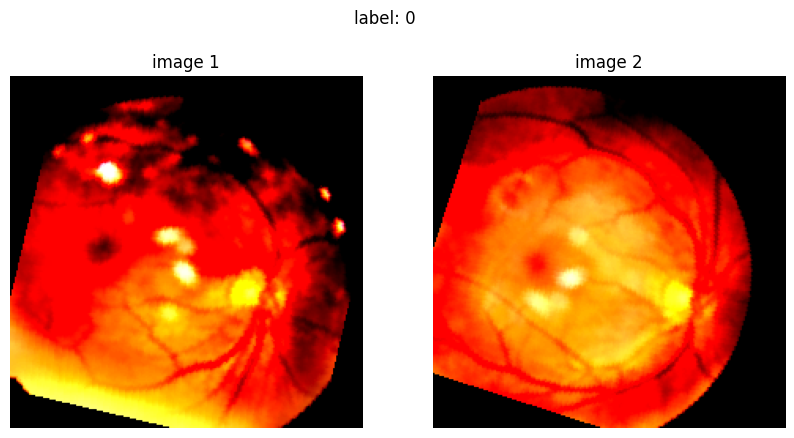

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


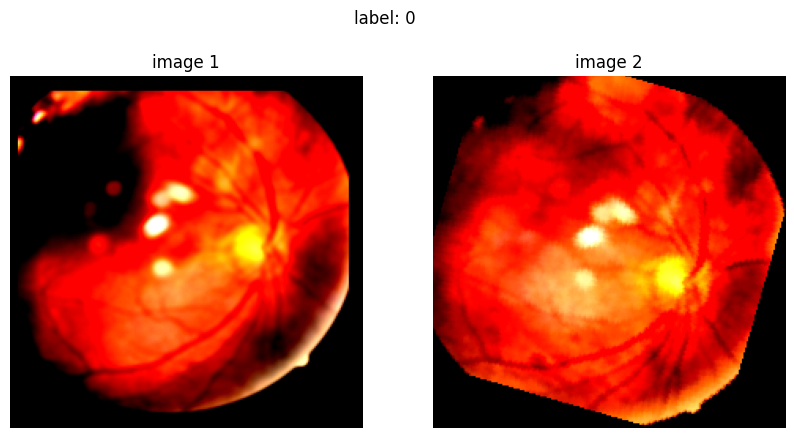

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


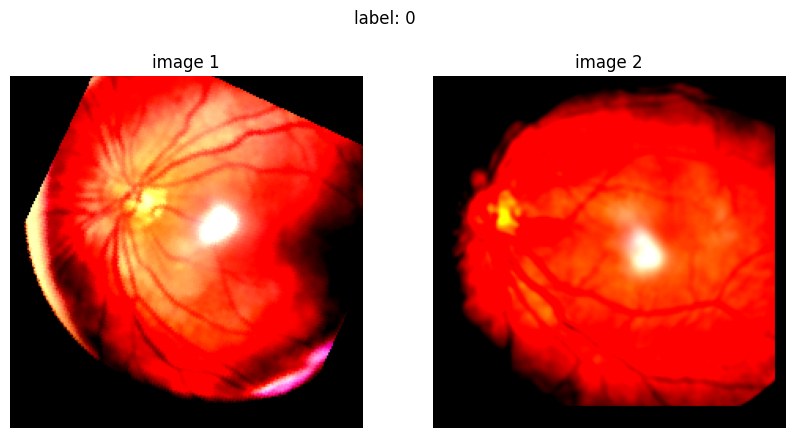

In [ ]:
import matplotlib.pyplot as plt

def visualize_preprocessing(dataset, num_samples=3):
    for i in range(num_samples):
        imgs, label = dataset[i]
        img1, img2 = imgs

        img1 = img1.permute(1, 2, 0).numpy()
        img2 = img2.permute(1, 2, 0).numpy()

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img1)
        plt.title("image 1")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img2)
        plt.title("image 2")
        plt.axis('off')

        plt.suptitle(f"label: {label}")
        plt.show()

visualize_preprocessing(train_dataset)

based on the results, removing color.jitter and adding circular cropping along with CLAHE gives the best results.

# **Task E:** Creating Visualizations and Explainable AI

In [ ]:
def train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=25,
                checkpoint_path='model.pth'):
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0  # Initialize the best kappa score

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        model.train()

        with tqdm(total=len(train_loader), desc=f'Training', unit=' batch', file=sys.stdout) as pbar:
            for images, labels in train_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # single image case
                else:
                    images = [x.to(device) for x in images]  # dual images case

                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels.long())

                loss.backward()
                optimizer.step()

                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss.append(loss.item())

                pbar.set_postfix({'lr': f'{optimizer.param_groups[0]["lr"]:.1e}', 'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()

        epoch_loss = sum(running_loss) / len(running_loss)
        train_losses.append(epoch_loss)

        train_metrics = compute_metrics(all_preds, all_labels, per_class=False)
        _, train_accuracy, _, _ = train_metrics[:4]
        train_accuracies.append(train_accuracy)

        print(f'[Train] Accuracy: {train_accuracy:.4f} Loss: {epoch_loss:.4f}')

        # Validation metrics
        val_metrics = evaluate_model(model, val_loader, device)
        val_kappa, val_accuracy, _, _ = val_metrics[:4]
        val_losses.append(val_metrics[0])
        val_accuracies.append(val_accuracy)

        print(f'[Val] Accuracy: {val_accuracy:.4f} Loss: {val_metrics[0]:.4f}')

        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

    print(f'[Val] Best kappa: {best_val_kappa:.4f}, Epoch {best_epoch}')

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    # losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
set_random_seed(29)

mode = 'dual'
model = MyDualModel()

print(model, '\n')
print('Pipeline Mode:', mode)

# Create datasets
train_dataset = RetinopathyDataset('./DeepDRiD/train.csv', './DeepDRiD/train/', transform_train, mode)
val_dataset = RetinopathyDataset('./DeepDRiD/val.csv', './DeepDRiD/val/', transform_test, mode)
test_dataset = RetinopathyDataset('./DeepDRiD/test.csv', './DeepDRiD/test/', transform_test, mode, test=True)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Use GPU device is possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Move class weights to the device
model = model.to(device)

# Optimizer and Learning rate scheduler
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train and evaluate the model with the training and validation set
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, device, criterion, optimizer,
    lr_scheduler=lr_scheduler, num_epochs=num_epochs,
    checkpoint_path='./model_1.pth'
)

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

# Load the pretrained checkpoint
state_dict = torch.load('./model_1.pth', map_location='cpu')
model.load_state_dict(state_dict, strict=True)

# Make predictions on testing set and save the prediction results
evaluate_model(model, test_loader, device, test_only=True)

C:\Users\mehsanim24\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mehsanim24\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyDualModel(
  (backbone1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

KeyboardInterrupt: 

**GradCAM**

C:\Users\mehsanim24\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mehsanim24\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

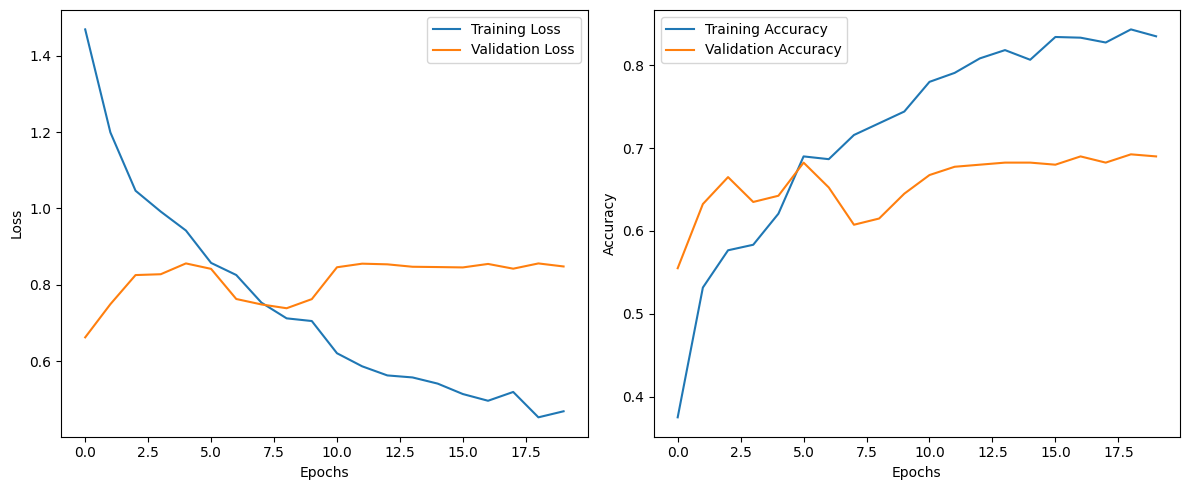

C:\Users\mehsanim24\AppData\Local\Temp\ipykernel_4508\439588576.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('./model_1.pth', map_location='c

Evaluating: 100%|██████████| 17/17 [00:03<00:00,  5.25 batch/s]
[Test] Save predictions to c:\Users\mehsanim24\Desktop\taskd-2\taskd-2\test_predictions.csv


In [ ]:
set_random_seed(29)

mode = 'single'
model = MyModel()

print(model, '\n')
print('Pipeline Mode:', mode)

# Create datasets
train_dataset = RetinopathyDataset('./DeepDRiD/train.csv', './DeepDRiD/train/', transform_train, mode)
val_dataset = RetinopathyDataset('./DeepDRiD/val.csv', './DeepDRiD/val/', transform_test, mode)
test_dataset = RetinopathyDataset('./DeepDRiD/test.csv', './DeepDRiD/test/', transform_test, mode, test=True)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Use GPU device is possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Move class weights to the device
model = model.to(device)

# Optimizer and Learning rate scheduler
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train and evaluate the model with the training and validation set
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, device, criterion, optimizer,
    lr_scheduler=lr_scheduler, num_epochs=num_epochs,
    checkpoint_path='./model_1.pth'
)

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

# Load the pretrained checkpoint
state_dict = torch.load('./model_1.pth', map_location='cpu')
model.load_state_dict(state_dict, strict=True)

# Make predictions on testing set and save the prediction results
evaluate_model(model, test_loader, device, test_only=True)

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(input_tensor)
        pred = output[:, class_idx]
        pred.backward(retain_graph=True)

        gradients = self.gradients
        activations = self.activations
        weights = torch.mean(gradients, dim=(2, 3))

        cam = torch.zeros(activations.shape[2:], dtype=torch.float32).to(input_tensor.device)
        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i]

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam.cpu().detach().numpy()

In [ ]:
from torchvision.transforms import ToPILImage

def show_gradcam(image, cam, alpha=0.5):
    cam = cv2.resize(cam, (image.shape[2], image.shape[1]))
    cam = np.uint8(255 * cam)

    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    image = np.array(ToPILImage()(image.squeeze()))
    overlayed_image = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

    return overlayed_image


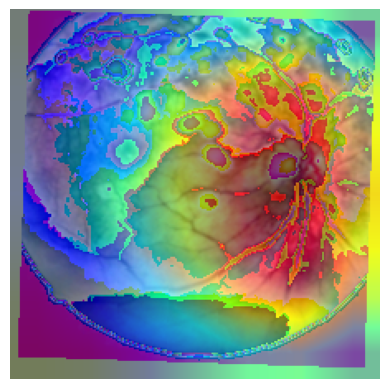

In [ ]:
model.eval()
gradcam = GradCAM(model, model.backbone.layer4[-1])

input_image, label = train_dataset[0]
input_image = input_image.unsqueeze(0)
input_image = input_image.to(device)

output = model(input_image)
class_idx = torch.argmax(output).item()
cam = gradcam.generate_cam(input_image, class_idx)


input_image_vis = input_image[0].cpu()
plt.imshow(show_gradcam(input_image_vis, cam))
plt.axis('off')
plt.show()

